In [3]:
import pandas as pd


# Load the dataset
file_path = '/content/violencedataset.csv'
dataset = pd.read_csv(file_path, encoding='ISO-8859-1')

# Display the first few rows
print(dataset.head())


      Tweet_ID                                              text   \
0  ID_0022DWKP  Had a dream i got raped last night. By a guy i...   
1  ID_0058QG76  My Husband Beats Me Frequently, Wife Tells Cou...   
2  ID_004BBHOD  I was sexually abused for 3 years at age 4 to ...   
3  ID_004F7516  !!! RT @mayasolovely: As a woman you shouldn't...   
4  ID_0052TYKI    " momma said no pussy cats inside my doghouse "   

            category  label  
0    sexual_violence      0  
1  physical_violence      1  
2    sexual_violence      0  
3       non_violence      2  
4       non_violence      2  


In [7]:
# Check the column names
print(dataset.columns)


Index(['Tweet_ID', 'text ', 'category', 'label', 'cleaned_text'], dtype='object')


In [8]:
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download stopwords if not already available
import nltk
nltk.download('stopwords')
nltk.download('punkt')

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    text = re.sub(r'\@\w+|\#','', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return ' '.join(filtered_text)

# Apply the cleaning function to the 'text ' column
dataset['cleaned_text'] = dataset['text '].apply(clean_text)

# Display the first few cleaned texts
print(dataset[['text ', 'cleaned_text']].head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                               text   \
0  Had a dream i got raped last night. By a guy i...   
1  My Husband Beats Me Frequently, Wife Tells Cou...   
2  I was sexually abused for 3 years at age 4 to ...   
3  !!! RT @mayasolovely: As a woman you shouldn't...   
4    " momma said no pussy cats inside my doghouse "   

                                        cleaned_text  
0  dream got raped last night guy work actually g...  
1          husband beats frequently wife tells court  
2  sexually abused 3 years age 4 7 one believed r...  
3  rt woman shouldnt complain cleaning house amp ...  
4              momma said pussy cats inside doghouse  


In [9]:
from sklearn.model_selection import train_test_split

# Define features and labels
X = dataset['cleaned_text']
y = dataset['label']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Training samples: {len(X_train)}')
print(f'Testing samples: {len(X_test)}')


Training samples: 9157
Testing samples: 2290


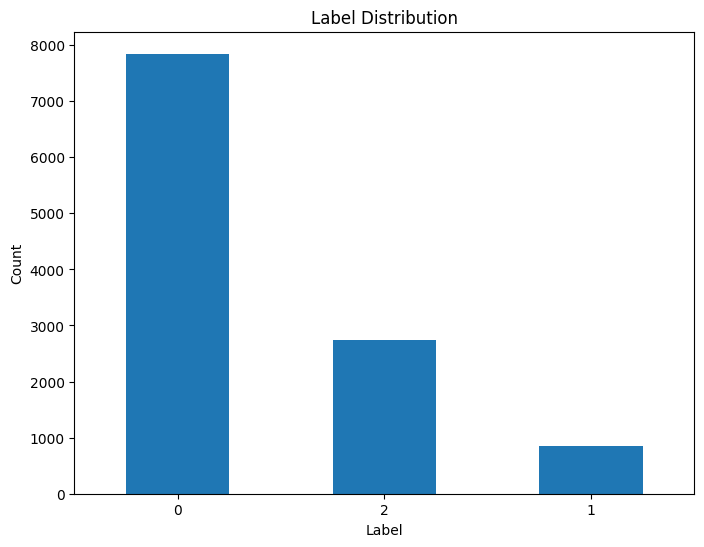

In [10]:
import matplotlib.pyplot as plt

# Plot label distribution
plt.figure(figsize=(8, 6))
dataset['label'].value_counts().plot(kind='bar')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


In [18]:
from torch.utils.data import Dataset
import torch
from transformers import BertTokenizer

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class ViolenceDataset(Dataset):
    def __init__(self, texts, labels):
        # Store texts and labels
        self.texts = texts
        self.labels = labels

    def __len__(self):
        # Return the number of samples
        return len(self.texts)

    def __getitem__(self, idx):
        # Get the text and label for a given index
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]

        # Tokenize the text
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            return_attention_mask=True,
            truncation=True,
            return_tensors='pt'
        )

        # Return a dictionary with the input IDs, attention mask, and label
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [19]:
from transformers import BertTokenizer

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Sample texts from the dataset
sample_texts = dataset['text '].head(3).tolist()

# Display the original texts and their tokenized and encoded forms
for i, text in enumerate(sample_texts):
    # Tokenization: Split text into tokens
    tokens = tokenizer.tokenize(text)
    # Encoding: Convert tokens to input IDs
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,  # Add [CLS] and [SEP] tokens
        max_length=128,  # Maximum length of the sequence
        padding='max_length',  # Pad sequences to the same length
        return_attention_mask=True,  # Return attention masks
        truncation=True,  # Truncate sequences longer than max_length
        return_tensors='pt'  # Return PyTorch tensors
    )

    input_ids = encoding['input_ids'].flatten()
    attention_mask = encoding['attention_mask'].flatten()

    # Display the results
    print(f"Example {i+1}:")
    print("Original Text:")
    print(text)
    print("\nTokens:")
    print(tokens)
    print("\nInput IDs:")
    print(input_ids.tolist())
    print("\nAttention Mask:")
    print(attention_mask.tolist())
    print("\n" + "="*50 + "\n")


Example 1:
Original Text:
Had a dream i got raped last night. By a guy i work with. Actually a guy i smoked with once at my house but he was doing too much tryna be sexual and it wasnât even like that for me just wanted to smoke.

Tokens:
['had', 'a', 'dream', 'i', 'got', 'raped', 'last', 'night', '.', 'by', 'a', 'guy', 'i', 'work', 'with', '.', 'actually', 'a', 'guy', 'i', 'smoked', 'with', 'once', 'at', 'my', 'house', 'but', 'he', 'was', 'doing', 'too', 'much', 'try', '##na', 'be', 'sexual', 'and', 'it', 'wasn', '##at', 'even', 'like', 'that', 'for', 'me', 'just', 'wanted', 'to', 'smoke', '.']

Input IDs:
[101, 2018, 1037, 3959, 1045, 2288, 15504, 2197, 2305, 1012, 2011, 1037, 3124, 1045, 2147, 2007, 1012, 2941, 1037, 3124, 1045, 20482, 2007, 2320, 2012, 2026, 2160, 2021, 2002, 2001, 2725, 2205, 2172, 3046, 2532, 2022, 4424, 1998, 2009, 2347, 4017, 2130, 2066, 2008, 2005, 2033, 2074, 2359, 2000, 5610, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [22]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
# Create DataLoader for train and test datasets
train_dataset = ViolenceDataset(X_train, y_train)
test_dataset = ViolenceDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Display a few batches from the DataLoader
for i, batch in enumerate(train_loader):
    if i >= 2:  # Display only first two batches for brevity
        break

    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['labels']

    print(f"Batch {i+1}:")
    print("Input IDs:\n", input_ids)
    print("Attention Mask:\n", attention_mask)
    print("Labels:\n", labels)
    print("\n" + "="*50 + "\n")

Batch 1:
Input IDs:
 tensor([[  101,  2145,  3173,  ...,     0,     0,     0],
        [  101,  2158,  7944,  ...,     0,     0,     0],
        [  101, 15504,  2145,  ...,     0,     0,     0],
        ...,
        [  101,  5306,  2619,  ...,     0,     0,     0],
        [  101, 26960,  2099,  ...,     0,     0,     0],
        [  101,  3756, 13029,  ...,     0,     0,     0]])
Attention Mask:
 tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
Labels:
 tensor([0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2])


Batch 2:
Input IDs:
 tensor([[  101,  2767,  3067,  ...,     0,     0,     0],
        [  101,  6445, 11387,  ...,     0,     0,     0],
        [  101,  4914, 15504,  ...,     0,     0,     0],
        ...,
        [  101,  6445, 11387,  ...,     0,     0,     0],
        [  101,  2340,  2086,  ...,     0,     0

In [23]:
!pip install transformers


In [24]:
from transformers import BertTokenizer, BertForSequenceClassification

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
from transformers import AdamW

# Define different learning rates to experiment with
learning_rates = [5e-5, 3e-5, 2e-5]

# Create a dictionary to store optimizers with different learning rates
optimizers = {
    f"lr_{lr}": AdamW(model.parameters(), lr=lr)
    for lr in learning_rates
}


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [26]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# Split the dataset into train and test sets
X = dataset['cleaned_text']
y = dataset['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create datasets
train_dataset = ViolenceDataset(X_train, y_train)
test_dataset = ViolenceDataset(X_test, y_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Training function
def train_model(optimizer, learning_rate, num_epochs=3):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Learning Rate {learning_rate}, Loss: {avg_loss}")

# Select the first learning rate for demonstration
chosen_lr = learning_rates[0]
train_model(optimizers[f"lr_{chosen_lr}"], chosen_lr)


Epoch 1/3, Learning Rate 5e-05, Loss: 0.0601486488961392
Epoch 2/3, Learning Rate 5e-05, Loss: 0.019029516649274415
Epoch 3/3, Learning Rate 5e-05, Loss: 0.00943099685971435


In [27]:
!pip install transformers torch scikit-learn matplotlib

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

Epoch 1/10, Learning Rate 5e-05, Train Loss: 0.0151, Val Loss: 0.0100
Epoch 2/10, Learning Rate 5e-05, Train Loss: 0.0092, Val Loss: 0.0098
Epoch 3/10, Learning Rate 5e-05, Train Loss: 0.0105, Val Loss: 0.0138
Epoch 4/10, Learning Rate 5e-05, Train Loss: 0.0159, Val Loss: 0.0207
Epoch 5/10, Learning Rate 5e-05, Train Loss: 0.0256, Val Loss: 0.0129
Epoch 6/10, Learning Rate 5e-05, Train Loss: 0.0356, Val Loss: 0.0182
Epoch 7/10, Learning Rate 5e-05, Train Loss: 0.0105, Val Loss: 0.0186
Epoch 8/10, Learning Rate 5e-05, Train Loss: 0.0453, Val Loss: 0.2225
Epoch 9/10, Learning Rate 5e-05, Train Loss: 0.0574, Val Loss: 0.0255
Epoch 10/10, Learning Rate 5e-05, Train Loss: 0.1767, Val Loss: 0.2300
Epoch 1/10, Learning Rate 3e-05, Train Loss: 0.2202, Val Loss: 0.2056
Epoch 2/10, Learning Rate 3e-05, Train Loss: 0.2355, Val Loss: 0.2117
Epoch 3/10, Learning Rate 3e-05, Train Loss: 0.2100, Val Loss: 0.1932
Epoch 4/10, Learning Rate 3e-05, Train Loss: 0.1911, Val Loss: 0.1842
Epoch 5/10, Learnin

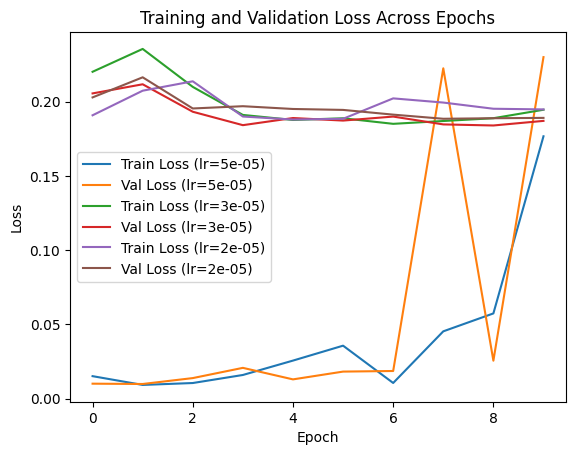

In [29]:
import matplotlib.pyplot as plt
def train_model(learning_rate, num_epochs=10):
    # Initialize the optimizer
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # Store loss values
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0

        for batch in train_loader:
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch + 1}/{num_epochs}, Learning Rate {learning_rate}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses

# Define different learning rates
learning_rates = [5e-5, 3e-5, 2e-5]

# Train and plot for each learning rate
for lr in learning_rates:
    train_losses, val_losses = train_model(lr)

    # Plot the losses
    plt.plot(train_losses, label=f'Train Loss (lr={lr})')
    plt.plot(val_losses, label=f'Val Loss (lr={lr})')

plt.title("Training and Validation Loss Across Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Epoch 1/10, Learning Rate 5e-05, Train Loss: 0.2025, Train Acc: 0.9208, Val Loss: 0.1934, Val Acc: 0.9219
Epoch 2/10, Learning Rate 5e-05, Train Loss: 0.1980, Train Acc: 0.9215, Val Loss: 0.1878, Val Acc: 0.9240
Epoch 3/10, Learning Rate 5e-05, Train Loss: 0.1858, Train Acc: 0.9235, Val Loss: 0.1816, Val Acc: 0.9240
Epoch 4/10, Learning Rate 5e-05, Train Loss: 0.2046, Train Acc: 0.9193, Val Loss: 0.7167, Val Acc: 0.6892
Epoch 5/10, Learning Rate 5e-05, Train Loss: 0.2379, Train Acc: 0.9109, Val Loss: 0.2196, Val Acc: 0.9149
Epoch 6/10, Learning Rate 5e-05, Train Loss: 0.2295, Train Acc: 0.9131, Val Loss: 0.2221, Val Acc: 0.9145
Epoch 7/10, Learning Rate 5e-05, Train Loss: 0.2198, Train Acc: 0.9153, Val Loss: 0.1928, Val Acc: 0.9227
Epoch 8/10, Learning Rate 5e-05, Train Loss: 0.2481, Train Acc: 0.9236, Val Loss: 0.2857, Val Acc: 0.9227
Epoch 9/10, Learning Rate 5e-05, Train Loss: 0.2599, Train Acc: 0.9240, Val Loss: 0.2592, Val Acc: 0.9245
Epoch 10/10, Learning Rate 5e-05, Train Loss: 

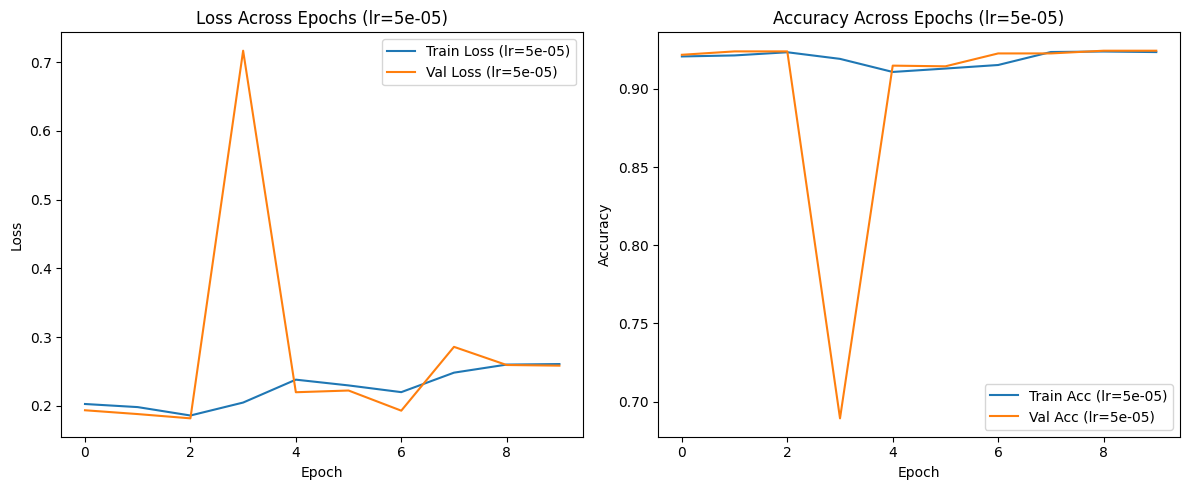

Epoch 1/10, Learning Rate 3e-05, Train Loss: 0.2914, Train Acc: 0.9152, Val Loss: 0.2759, Val Acc: 0.9223
Epoch 2/10, Learning Rate 3e-05, Train Loss: 0.2613, Train Acc: 0.9239, Val Loss: 0.2579, Val Acc: 0.9245
Epoch 3/10, Learning Rate 3e-05, Train Loss: 0.2581, Train Acc: 0.9243, Val Loss: 0.2577, Val Acc: 0.9245
Epoch 4/10, Learning Rate 3e-05, Train Loss: 0.2664, Train Acc: 0.9243, Val Loss: 0.2694, Val Acc: 0.9232
Epoch 5/10, Learning Rate 3e-05, Train Loss: 0.2610, Train Acc: 0.9241, Val Loss: 0.2628, Val Acc: 0.9240
Epoch 6/10, Learning Rate 3e-05, Train Loss: 0.2575, Train Acc: 0.9246, Val Loss: 0.2625, Val Acc: 0.9240
Epoch 7/10, Learning Rate 3e-05, Train Loss: 0.2569, Train Acc: 0.9244, Val Loss: 0.2619, Val Acc: 0.9240
Epoch 8/10, Learning Rate 3e-05, Train Loss: 0.2554, Train Acc: 0.9246, Val Loss: 0.2629, Val Acc: 0.9240
Epoch 9/10, Learning Rate 3e-05, Train Loss: 0.2556, Train Acc: 0.9248, Val Loss: 0.2633, Val Acc: 0.9240
Epoch 10/10, Learning Rate 3e-05, Train Loss: 

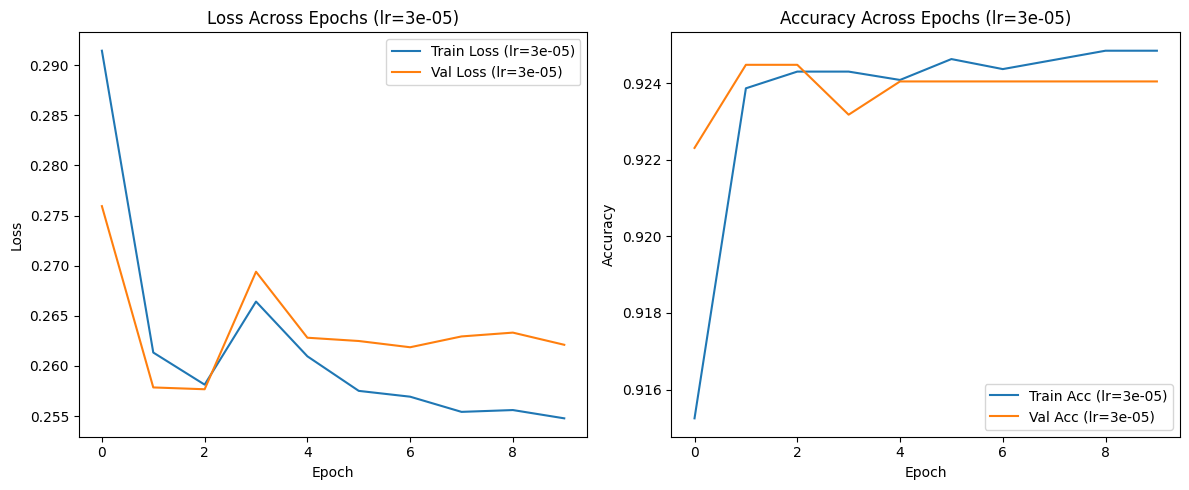

Epoch 1/10, Learning Rate 2e-05, Train Loss: 0.2546, Train Acc: 0.9248, Val Loss: 0.2632, Val Acc: 0.9240
Epoch 2/10, Learning Rate 2e-05, Train Loss: 0.2559, Train Acc: 0.9247, Val Loss: 0.2580, Val Acc: 0.9245
Epoch 3/10, Learning Rate 2e-05, Train Loss: 0.2590, Train Acc: 0.9241, Val Loss: 0.2580, Val Acc: 0.9245
Epoch 4/10, Learning Rate 2e-05, Train Loss: 0.2560, Train Acc: 0.9246, Val Loss: 0.2598, Val Acc: 0.9245
Epoch 5/10, Learning Rate 2e-05, Train Loss: 0.2569, Train Acc: 0.9242, Val Loss: 0.2599, Val Acc: 0.9245
Epoch 6/10, Learning Rate 2e-05, Train Loss: 0.2575, Train Acc: 0.9242, Val Loss: 0.2589, Val Acc: 0.9245
Epoch 7/10, Learning Rate 2e-05, Train Loss: 0.2573, Train Acc: 0.9242, Val Loss: 0.2633, Val Acc: 0.9240
Epoch 8/10, Learning Rate 2e-05, Train Loss: 0.2554, Train Acc: 0.9245, Val Loss: 0.2635, Val Acc: 0.9240
Epoch 9/10, Learning Rate 2e-05, Train Loss: 0.2563, Train Acc: 0.9245, Val Loss: 0.2626, Val Acc: 0.9240
Epoch 10/10, Learning Rate 2e-05, Train Loss: 

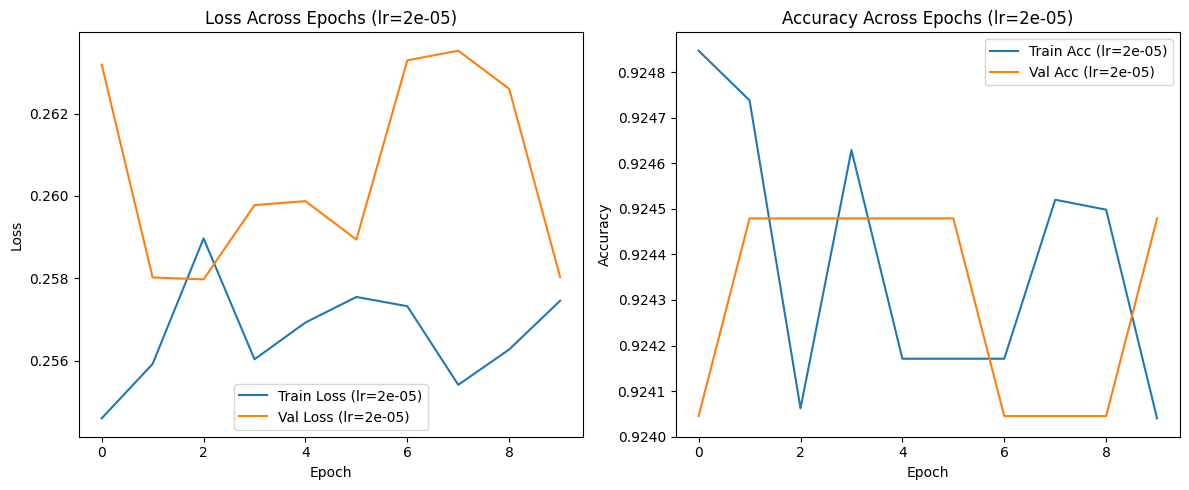

In [33]:
import torch
import matplotlib.pyplot as plt
from transformers import AdamW

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def train_model(learning_rate, num_epochs=10):
    # Initialize the optimizer
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # Store loss and accuracy values
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        total_train_accuracy = 0

        for batch in train_loader:
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            total_train_loss += loss.item()

            # Calculate accuracy for this batch
            logits = logits.detach().cpu().numpy()
            label_ids = labels.to('cpu').numpy()
            batch_accuracy = flat_accuracy(logits, label_ids)
            total_train_accuracy += batch_accuracy

            loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_accuracy = total_train_accuracy / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)

        # Validation phase
        model.eval()
        total_val_loss = 0
        total_val_accuracy = 0

        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits
                total_val_loss += loss.item()

                # Calculate accuracy for this batch
                logits = logits.detach().cpu().numpy()
                label_ids = labels.to('cpu').numpy()
                batch_accuracy = flat_accuracy(logits, label_ids)
                total_val_accuracy += batch_accuracy

        avg_val_loss = total_val_loss / len(test_loader)
        avg_val_accuracy = total_val_accuracy / len(test_loader)
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Learning Rate {learning_rate}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_accuracy:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Define different learning rates
learning_rates = [5e-5, 3e-5, 2e-5]

# Train and plot for each learning rate
for lr in learning_rates:
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(lr)

    # Plot the losses
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label=f'Train Loss (lr={lr})')
    plt.plot(val_losses, label=f'Val Loss (lr={lr})')
    plt.title(f"Loss Across Epochs (lr={lr})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Plot the accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label=f'Train Acc (lr={lr})')
    plt.plot(val_accuracies, label=f'Val Acc (lr={lr})')
    plt.title(f"Accuracy Across Epochs (lr={lr})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [34]:
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def evaluate_model_on_test_data(model, test_loader):
    # Set the model to evaluation mode
    model.eval()

    all_predictions = []
    all_true_labels = []

    # Iterate over batches in the test loader
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.no_grad():
            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask)

        # Get the logits
        logits = outputs.logits

        # Convert logits to predicted class labels
        predictions = np.argmax(logits.detach().cpu().numpy(), axis=1)
        true_labels = labels.cpu().numpy()

        # Collect predictions and true labels
        all_predictions.extend(predictions)
        all_true_labels.extend(true_labels)

    # Calculate evaluation metrics
    accuracy = accuracy_score(all_true_labels, all_predictions)
    class_report = classification_report(all_true_labels, all_predictions, target_names=['Sexual Violence', 'Physical Violence', 'Non-Violence'])
    conf_matrix = confusion_matrix(all_true_labels, all_predictions)

    # Print evaluation results
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(class_report)
    print("Confusion Matrix:")
    print(conf_matrix)

    return accuracy, class_report, conf_matrix

# Evaluate the model on test data
evaluate_model_on_test_data(model, test_loader)


Accuracy: 0.9240
Classification Report:
                   precision    recall  f1-score   support

  Sexual Violence       0.90      1.00      0.95      1581
Physical Violence       0.00      0.00      0.00       171
     Non-Violence       0.99      1.00      0.99       538

         accuracy                           0.92      2290
        macro avg       0.63      0.67      0.65      2290
     weighted avg       0.86      0.92      0.89      2290

Confusion Matrix:
[[1578    0    3]
 [ 167    0    4]
 [   0    0  538]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.9240174672489083,
 '                   precision    recall  f1-score   support\n\n  Sexual Violence       0.90      1.00      0.95      1581\nPhysical Violence       0.00      0.00      0.00       171\n     Non-Violence       0.99      1.00      0.99       538\n\n         accuracy                           0.92      2290\n        macro avg       0.63      0.67      0.65      2290\n     weighted avg       0.86      0.92      0.89      2290\n',
 array([[1578,    0,    3],
        [ 167,    0,    4],
        [   0,    0,  538]]))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9240
Classification Report:
                   precision    recall  f1-score   support

  Sexual Violence       0.90      1.00      0.95      1581
Physical Violence       0.00      0.00      0.00       171
     Non-Violence       0.99      1.00      0.99       538

         accuracy                           0.92      2290
        macro avg       0.63      0.67      0.65      2290
     weighted avg       0.86      0.92      0.89      2290



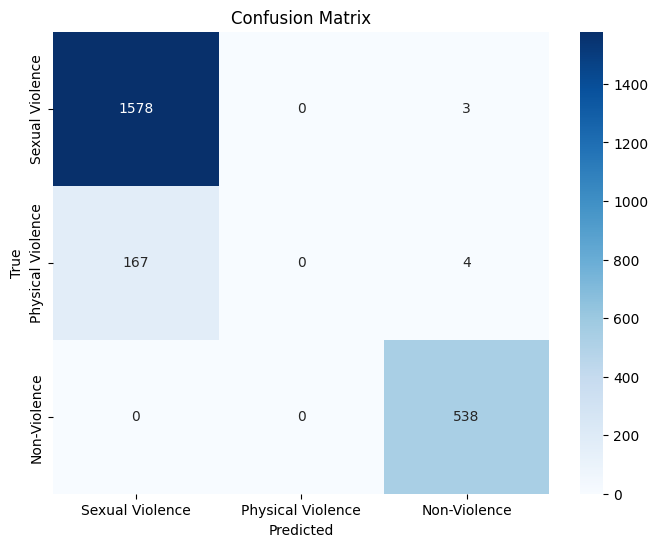

(0.9240174672489083,
 '                   precision    recall  f1-score   support\n\n  Sexual Violence       0.90      1.00      0.95      1581\nPhysical Violence       0.00      0.00      0.00       171\n     Non-Violence       0.99      1.00      0.99       538\n\n         accuracy                           0.92      2290\n        macro avg       0.63      0.67      0.65      2290\n     weighted avg       0.86      0.92      0.89      2290\n',
 array([[1578,    0,    3],
        [ 167,    0,    4],
        [   0,    0,  538]]))

In [35]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def evaluate_and_plot_confusion_matrix(model, test_loader):
    # Set the model to evaluation mode
    model.eval()

    all_predictions = []
    all_true_labels = []

    # Iterate over batches in the test loader
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.no_grad():
            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask)

        # Get the logits
        logits = outputs.logits

        # Convert logits to predicted class labels
        predictions = np.argmax(logits.detach().cpu().numpy(), axis=1)
        true_labels = labels.cpu().numpy()

        # Collect predictions and true labels
        all_predictions.extend(predictions)
        all_true_labels.extend(true_labels)

    # Calculate evaluation metrics
    accuracy = accuracy_score(all_true_labels, all_predictions)
    class_report = classification_report(all_true_labels, all_predictions, target_names=['Sexual Violence', 'Physical Violence', 'Non-Violence'])
    conf_matrix = confusion_matrix(all_true_labels, all_predictions)

    # Print evaluation results
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(class_report)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sexual Violence', 'Physical Violence', 'Non-Violence'], yticklabels=['Sexual Violence', 'Physical Violence', 'Non-Violence'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, class_report, conf_matrix

# Evaluate the model on test data and plot the confusion matrix
evaluate_and_plot_confusion_matrix(model, test_loader)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9240
Classification Report:
                   precision    recall  f1-score   support

  Sexual Violence       0.90      1.00      0.95      1581
Physical Violence       0.00      0.00      0.00       171
     Non-Violence       0.99      1.00      0.99       538

         accuracy                           0.92      2290
        macro avg       0.63      0.67      0.65      2290
     weighted avg       0.86      0.92      0.89      2290



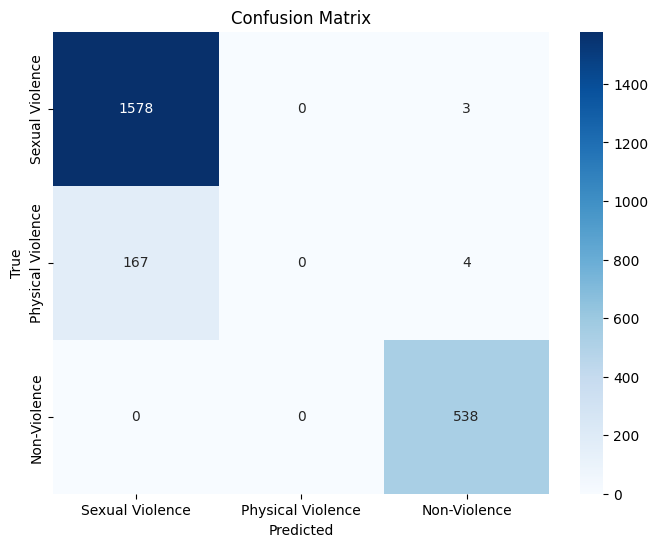

(0.9240174672489083,
 '                   precision    recall  f1-score   support\n\n  Sexual Violence       0.90      1.00      0.95      1581\nPhysical Violence       0.00      0.00      0.00       171\n     Non-Violence       0.99      1.00      0.99       538\n\n         accuracy                           0.92      2290\n        macro avg       0.63      0.67      0.65      2290\n     weighted avg       0.86      0.92      0.89      2290\n',
 array([[1578,    0,    3],
        [ 167,    0,    4],
        [   0,    0,  538]]))

In [38]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def evaluate_and_plot_confusion_matrix(model, test_loader):
    # Set the model to evaluation mode
    model.eval()

    all_predictions = []
    all_true_labels = []

    # Iterate over batches in the test loader
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.no_grad():
            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask)

        # Get the logits
        logits = outputs.logits

        # Ensure logits are in the correct shape (batch_size, num_labels)
        if logits.ndim == 1:
            logits = logits.unsqueeze(0)

        # Convert logits to predicted class labels
        predictions = np.argmax(logits.detach().cpu().numpy(), axis=1)
        true_labels = labels.cpu().numpy()

        # Collect predictions and true labels
        all_predictions.extend(predictions)
        all_true_labels.extend(true_labels)

    # Calculate evaluation metrics
    accuracy = accuracy_score(all_true_labels, all_predictions)
    class_report = classification_report(all_true_labels, all_predictions, target_names=['Sexual Violence', 'Physical Violence', 'Non-Violence'])
    conf_matrix = confusion_matrix(all_true_labels, all_predictions)

    # Print evaluation results
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(class_report)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sexual Violence', 'Physical Violence', 'Non-Violence'], yticklabels=['Sexual Violence', 'Physical Violence', 'Non-Violence'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, class_report, conf_matrix

# Ensure model and test_loader are defined
evaluate_and_plot_confusion_matrix(model, test_loader)


In [41]:
import torch
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

def flat_accuracy(preds, labels):
    """Calculate the accuracy of predictions vs true labels."""
    pred_flat = preds.flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def train_model_with_weights(learning_rate, num_epochs=10):
    # Compute class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(train_dataset.labels), y=train_dataset.labels)
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    # Define the loss function with class weights
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

    # Initialize the optimizer
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # Store loss and accuracy values
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        total_train_accuracy = 0

        for batch in train_loader:
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            loss = criterion(logits, labels)
            total_train_loss += loss.item()

            # Convert logits to predicted class labels
            predictions = np.argmax(logits.detach().cpu().numpy(), axis=1)
            true_labels = labels.cpu().numpy()

            # Calculate accuracy for this batch
            batch_accuracy = flat_accuracy(predictions, true_labels)
            total_train_accuracy += batch_accuracy

            loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_accuracy = total_train_accuracy / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)

        # Validation phase
        model.eval()
        total_val_loss = 0
        total_val_accuracy = 0

        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits

                loss = criterion(logits, labels)
                total_val_loss += loss.item()

                # Convert logits to predicted class labels
                predictions = np.argmax(logits.detach().cpu().numpy(), axis=1)
                true_labels = labels.cpu().numpy()

                # Calculate accuracy for this batch
                batch_accuracy = flat_accuracy(predictions, true_labels)
                total_val_accuracy += batch_accuracy

        avg_val_loss = total_val_loss / len(test_loader)
        avg_val_accuracy = total_val_accuracy / len(test_loader)
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Learning Rate {learning_rate}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_accuracy:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train and evaluate for each learning rate
for lr in [5e-5, 3e-5, 2e-5]:
    print(f"Training with learning rate: {lr}")
    train_losses, val_losses, train_accuracies, val_accuracies = train_model_with_weights(lr)


Training with learning rate: 5e-05


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10, Learning Rate 5e-05, Train Loss: 0.4724, Train Acc: 0.8978, Val Loss: 0.5064, Val Acc: 0.9123
Epoch 2/10, Learning Rate 5e-05, Train Loss: 0.5240, Train Acc: 0.8563, Val Loss: 0.5380, Val Acc: 0.9028
Epoch 3/10, Learning Rate 5e-05, Train Loss: 0.5491, Train Acc: 0.8438, Val Loss: 0.5615, Val Acc: 0.8915
Epoch 4/10, Learning Rate 5e-05, Train Loss: 0.5636, Train Acc: 0.8373, Val Loss: 0.5899, Val Acc: 0.8824
Epoch 5/10, Learning Rate 5e-05, Train Loss: 0.5811, Train Acc: 0.8250, Val Loss: 0.6126, Val Acc: 0.8655
Epoch 6/10, Learning Rate 5e-05, Train Loss: 0.5928, Train Acc: 0.8134, Val Loss: 0.5790, Val Acc: 0.7604
Epoch 7/10, Learning Rate 5e-05, Train Loss: 0.5637, Train Acc: 0.8336, Val Loss: 0.5508, Val Acc: 0.8963
Epoch 8/10, Learning Rate 5e-05, Train Loss: 0.5654, Train Acc: 0.8346, Val Loss: 0.5740, Val Acc: 0.7604
Epoch 9/10, Learning Rate 5e-05, Train Loss: 0.5871, Train Acc: 0.8097, Val Loss: 0.6549, Val Acc: 0.7604
Epoch 10/10, Learning Rate 5e-05, Train Loss: 

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10, Learning Rate 3e-05, Train Loss: 1.1014, Train Acc: 0.4522, Val Loss: 1.0985, Val Acc: 0.6892
Epoch 2/10, Learning Rate 3e-05, Train Loss: 1.1041, Train Acc: 0.4865, Val Loss: 1.0937, Val Acc: 0.2365
Epoch 3/10, Learning Rate 3e-05, Train Loss: 1.1022, Train Acc: 0.4721, Val Loss: 1.0934, Val Acc: 0.6892
Epoch 4/10, Learning Rate 3e-05, Train Loss: 1.1027, Train Acc: 0.4983, Val Loss: 1.0963, Val Acc: 0.6892
Epoch 5/10, Learning Rate 3e-05, Train Loss: 1.1028, Train Acc: 0.4727, Val Loss: 1.0932, Val Acc: 0.6892
Epoch 6/10, Learning Rate 3e-05, Train Loss: 1.1015, Train Acc: 0.4601, Val Loss: 1.0944, Val Acc: 0.6892
Epoch 7/10, Learning Rate 3e-05, Train Loss: 1.1048, Train Acc: 0.4756, Val Loss: 1.0945, Val Acc: 0.6892
Epoch 8/10, Learning Rate 3e-05, Train Loss: 1.1022, Train Acc: 0.4897, Val Loss: 1.0959, Val Acc: 0.2365
Epoch 9/10, Learning Rate 3e-05, Train Loss: 1.1025, Train Acc: 0.4649, Val Loss: 1.0997, Val Acc: 0.6892
Epoch 10/10, Learning Rate 3e-05, Train Loss: 

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10, Learning Rate 2e-05, Train Loss: 1.1038, Train Acc: 0.4810, Val Loss: 1.0964, Val Acc: 0.6892
Epoch 2/10, Learning Rate 2e-05, Train Loss: 1.0990, Train Acc: 0.5035, Val Loss: 1.0962, Val Acc: 0.2365
Epoch 3/10, Learning Rate 2e-05, Train Loss: 1.1013, Train Acc: 0.4947, Val Loss: 1.0938, Val Acc: 0.6892
Epoch 4/10, Learning Rate 2e-05, Train Loss: 1.0994, Train Acc: 0.4940, Val Loss: 1.0934, Val Acc: 0.6892
Epoch 5/10, Learning Rate 2e-05, Train Loss: 1.1034, Train Acc: 0.4782, Val Loss: 1.0932, Val Acc: 0.6892
Epoch 6/10, Learning Rate 2e-05, Train Loss: 1.1016, Train Acc: 0.4967, Val Loss: 1.0938, Val Acc: 0.6892
Epoch 7/10, Learning Rate 2e-05, Train Loss: 1.1004, Train Acc: 0.4982, Val Loss: 1.0939, Val Acc: 0.6892
Epoch 8/10, Learning Rate 2e-05, Train Loss: 1.1018, Train Acc: 0.4839, Val Loss: 1.0963, Val Acc: 0.6892
Epoch 9/10, Learning Rate 2e-05, Train Loss: 1.0994, Train Acc: 0.4941, Val Loss: 1.0931, Val Acc: 0.6892
Epoch 10/10, Learning Rate 2e-05, Train Loss: 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.6904
Classification Report:
                   precision    recall  f1-score   support

  Sexual Violence       0.69      1.00      0.82      1581
Physical Violence       0.00      0.00      0.00       171
     Non-Violence       0.00      0.00      0.00       538

         accuracy                           0.69      2290
        macro avg       0.23      0.33      0.27      2290
     weighted avg       0.48      0.69      0.56      2290



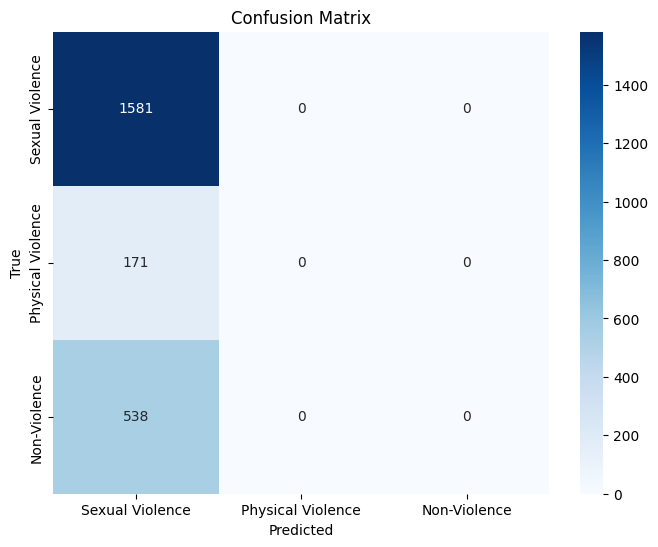

In [42]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def evaluate_and_predict(model, test_loader):
    # Set the model to evaluation mode
    model.eval()

    all_predictions = []
    all_true_labels = []

    # Iterate over batches in the test loader
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.no_grad():
            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask)

        # Get the logits
        logits = outputs.logits

        # Convert logits to predicted class labels
        predictions = np.argmax(logits.detach().cpu().numpy(), axis=1)
        true_labels = labels.cpu().numpy()

        # Collect predictions and true labels
        all_predictions.extend(predictions)
        all_true_labels.extend(true_labels)

    # Calculate evaluation metrics
    accuracy = accuracy_score(all_true_labels, all_predictions)
    class_report = classification_report(all_true_labels, all_predictions, target_names=['Sexual Violence', 'Physical Violence', 'Non-Violence'])
    conf_matrix = confusion_matrix(all_true_labels, all_predictions)

    # Print evaluation results
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(class_report)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sexual Violence', 'Physical Violence', 'Non-Violence'], yticklabels=['Sexual Violence', 'Physical Violence', 'Non-Violence'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return all_predictions, accuracy, class_report, conf_matrix

# Ensure model is trained and test_loader is prepared
predictions, accuracy, class_report, conf_matrix = evaluate_and_predict(model, test_loader)


In [43]:
from collections import Counter

def check_class_distribution(loader, label_name='labels'):
    all_labels = []
    for batch in loader:
        labels = batch[label_name].numpy()
        all_labels.extend(labels)

    counter = Counter(all_labels)
    total = sum(counter.values())
    for cls, count in counter.items():
        print(f"Class {cls}: {count} samples, {count / total:.2%} of total")

# Check distribution in training data
print("Training Data Distribution:")
check_class_distribution(train_loader)

# Check distribution in test data
print("Test Data Distribution:")
check_class_distribution(test_loader)


Training Data Distribution:
Class 0: 6265 samples, 68.42% of total
Class 2: 2211 samples, 24.15% of total
Class 1: 681 samples, 7.44% of total
Test Data Distribution:
Class 0: 1581 samples, 69.04% of total
Class 2: 538 samples, 23.49% of total
Class 1: 171 samples, 7.47% of total


In [44]:
# Inspect Model Training
# Define the training function with class weights
def train_model_with_weights(learning_rate, num_epochs=10):
    # Compute class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(train_dataset.labels), y=train_dataset.labels)
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    # Define the loss function with class weights
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

    # Initialize the optimizer
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # Store loss and accuracy values
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        total_train_accuracy = 0

        for batch in train_loader:
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            loss = criterion(logits, labels)
            total_train_loss += loss.item()

            # Convert logits to predicted class labels
            predictions = np.argmax(logits.detach().cpu().numpy(), axis=1)
            true_labels = labels.cpu().numpy()

            # Calculate accuracy for this batch
            batch_accuracy = flat_accuracy(predictions, true_labels)
            total_train_accuracy += batch_accuracy

            loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_accuracy = total_train_accuracy / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)

        # Validation phase
        model.eval()
        total_val_loss = 0
        total_val_accuracy = 0

        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits

                loss = criterion(logits, labels)
                total_val_loss += loss.item()

                # Convert logits to predicted class labels
                predictions = np.argmax(logits.detach().cpu().numpy(), axis=1)
                true_labels = labels.cpu().numpy()

                # Calculate accuracy for this batch
                batch_accuracy = flat_accuracy(predictions, true_labels)
                total_val_accuracy += batch_accuracy

        avg_val_loss = total_val_loss / len(test_loader)
        avg_val_accuracy = total_val_accuracy / len(test_loader)
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Learning Rate {learning_rate}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_accuracy:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Check the model's class weights
print("Training with learning rate: 2e-5")
train_losses, val_losses, train_accuracies, val_accuracies = train_model_with_weights(2e-5)


Training with learning rate: 2e-5


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10, Learning Rate 2e-05, Train Loss: 1.0999, Train Acc: 0.4910, Val Loss: 1.0939, Val Acc: 0.6892
Epoch 2/10, Learning Rate 2e-05, Train Loss: 1.1009, Train Acc: 0.4901, Val Loss: 1.0932, Val Acc: 0.6892
Epoch 3/10, Learning Rate 2e-05, Train Loss: 1.1026, Train Acc: 0.4858, Val Loss: 1.0977, Val Acc: 0.6892
Epoch 4/10, Learning Rate 2e-05, Train Loss: 1.1029, Train Acc: 0.4797, Val Loss: 1.0945, Val Acc: 0.6892
Epoch 5/10, Learning Rate 2e-05, Train Loss: 1.1025, Train Acc: 0.4953, Val Loss: 1.0941, Val Acc: 0.6892
Epoch 6/10, Learning Rate 2e-05, Train Loss: 1.1036, Train Acc: 0.4795, Val Loss: 1.0965, Val Acc: 0.6892
Epoch 7/10, Learning Rate 2e-05, Train Loss: 1.1012, Train Acc: 0.5007, Val Loss: 1.0936, Val Acc: 0.6892
Epoch 8/10, Learning Rate 2e-05, Train Loss: 1.1006, Train Acc: 0.4778, Val Loss: 1.0942, Val Acc: 0.2365
Epoch 9/10, Learning Rate 2e-05, Train Loss: 1.1013, Train Acc: 0.4980, Val Loss: 1.0972, Val Acc: 0.6892
Epoch 10/10, Learning Rate 2e-05, Train Loss: 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.6904
Classification Report:
                   precision    recall  f1-score   support

  Sexual Violence       0.69      1.00      0.82      1581
Physical Violence       0.00      0.00      0.00       171
     Non-Violence       0.00      0.00      0.00       538

         accuracy                           0.69      2290
        macro avg       0.23      0.33      0.27      2290
     weighted avg       0.48      0.69      0.56      2290



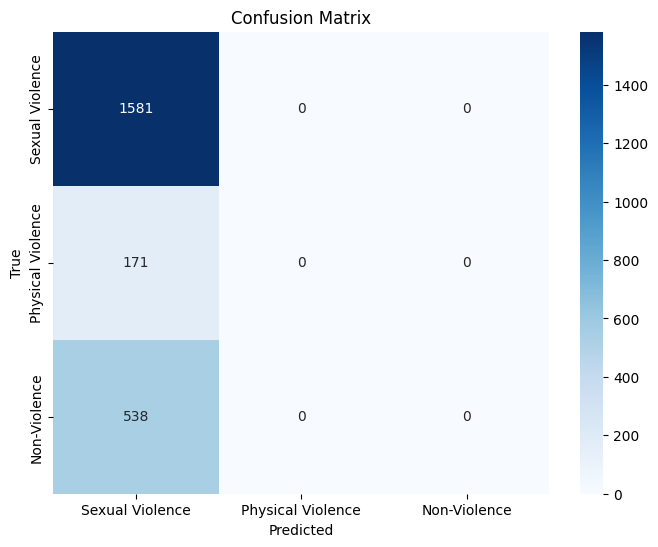

In [45]:
#Evaluate and Plot Predictions
def evaluate_and_predict(model, test_loader):
    # Set the model to evaluation mode
    model.eval()

    all_predictions = []
    all_true_labels = []

    # Iterate over batches in the test loader
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.no_grad():
            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask)

        # Get the logits
        logits = outputs.logits

        # Convert logits to predicted class labels
        predictions = np.argmax(logits.detach().cpu().numpy(), axis=1)
        true_labels = labels.cpu().numpy()

        # Collect predictions and true labels
        all_predictions.extend(predictions)
        all_true_labels.extend(true_labels)

    # Calculate evaluation metrics
    accuracy = accuracy_score(all_true_labels, all_predictions)
    class_report = classification_report(all_true_labels, all_predictions, target_names=['Sexual Violence', 'Physical Violence', 'Non-Violence'])
    conf_matrix = confusion_matrix(all_true_labels, all_predictions)

    # Print evaluation results
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(class_report)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sexual Violence', 'Physical Violence', 'Non-Violence'], yticklabels=['Sexual Violence', 'Physical Violence', 'Non-Violence'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return all_predictions, accuracy, class_report, conf_matrix

# Evaluate the model on test data
predictions, accuracy, class_report, conf_matrix = evaluate_and_predict(model, test_loader)


In [53]:
#Undersample the Majority Class
from imblearn.under_sampling import RandomUnderSampler
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

import pandas as pd

# Load your data
data = pd.read_csv('/content/violencedataset.csv', encoding='ISO-8859-1')

# Assuming 'texts' and 'labels' are Series from your DataFrame
texts = data['text ']
labels = data['label']

# Convert to NumPy arrays
X = texts.values
y = labels.values

# Reshape X to fit the requirement of RandomUnderSampler
X = X.reshape(-1, 1)

# Perform random undersampling
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Convert resampled data back to the required format
X_resampled = X_resampled.flatten()

# Split the resampled data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 128

# Create the dataset instances
train_dataset_resampled = CustomDataset(
    texts=X_train,
    labels=y_train,
    tokenizer=tokenizer,
    max_len=max_len
)

test_dataset_resampled = CustomDataset(
    texts=X_test,
    labels=y_test,
    tokenizer=tokenizer,
    max_len=max_len
)

# Create the DataLoader instances
train_loader_resampled = DataLoader(
    train_dataset_resampled,
    batch_size=16,
    shuffle=True
)

test_loader_resampled = DataLoader(
    test_dataset_resampled,
    batch_size=16,
    shuffle=False
)




In [55]:
#Train the Model with Different Class Weights
#Using SGD Optimizer
import torch.optim as optim

def train_model_with_class_weights(learning_rate, class_weights, num_epochs=10):
    # Define the loss function with class weights
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

    # Initialize the SGD optimizer
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    # Store loss and accuracy values
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        total_train_accuracy = 0

        for batch in train_loader_resampled:
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            loss = criterion(logits, labels)
            total_train_loss += loss.item()

            # Convert logits to predicted class labels
            predictions = np.argmax(logits.detach().cpu().numpy(), axis=1)
            true_labels = labels.cpu().numpy()

            # Calculate accuracy for this batch
            batch_accuracy = flat_accuracy(predictions, true_labels)
            total_train_accuracy += batch_accuracy

            loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader_resampled)
        avg_train_accuracy = total_train_accuracy / len(train_loader_resampled)
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)

        # Validation phase
        model.eval()
        total_val_loss = 0
        total_val_accuracy = 0

        with torch.no_grad():
            for batch in test_loader_resampled:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits

                loss = criterion(logits, labels)
                total_val_loss += loss.item()

                # Convert logits to predicted class labels
                predictions = np.argmax(logits.detach().cpu().numpy(), axis=1)
                true_labels = labels.cpu().numpy()

                # Calculate accuracy for this batch
                batch_accuracy = flat_accuracy(predictions, true_labels)
                total_val_accuracy += batch_accuracy

        avg_val_loss = total_val_loss / len(test_loader_resampled)
        avg_val_accuracy = total_val_accuracy / len(test_loader_resampled)
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Learning Rate {learning_rate}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_accuracy:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Experiment with different class weights
class_weights_options = [
    torch.tensor([1.0, 2.0, 2.0], dtype=torch.float).to(device),
    torch.tensor([1.0, 3.0, 3.0], dtype=torch.float).to(device),
    torch.tensor([1.0, 5.0, 5.0], dtype=torch.float).to(device)
]

# Train the model with different class weights
for class_weights in class_weights_options:
    print(f"Training with class weights: {class_weights.cpu().numpy()}")
    train_losses, val_losses, train_accuracies, val_accuracies = train_model_with_class_weights(0.01, class_weights)


Training with class weights: [1. 2. 2.]
Epoch 1/10, Learning Rate 0.01, Train Loss: 3.7783, Train Acc: 0.3438, Val Loss: 9.2611, Val Acc: 0.3398
Epoch 2/10, Learning Rate 0.01, Train Loss: 2.6918, Train Acc: 0.3439, Val Loss: 1.4001, Val Acc: 0.3086
Epoch 3/10, Learning Rate 0.01, Train Loss: 1.9275, Train Acc: 0.3268, Val Loss: 1.2066, Val Acc: 0.3398
Epoch 4/10, Learning Rate 0.01, Train Loss: 2.0641, Train Acc: 0.3369, Val Loss: 2.7175, Val Acc: 0.3398
Epoch 5/10, Learning Rate 0.01, Train Loss: 2.0095, Train Acc: 0.3411, Val Loss: 1.4811, Val Acc: 0.3398
Epoch 6/10, Learning Rate 0.01, Train Loss: 1.6282, Train Acc: 0.3218, Val Loss: 1.2094, Val Acc: 0.3516
Epoch 7/10, Learning Rate 0.01, Train Loss: 1.6899, Train Acc: 0.3060, Val Loss: 1.2585, Val Acc: 0.3086
Epoch 8/10, Learning Rate 0.01, Train Loss: 1.5744, Train Acc: 0.3234, Val Loss: 1.5428, Val Acc: 0.3398
Epoch 9/10, Learning Rate 0.01, Train Loss: 1.4262, Train Acc: 0.3237, Val Loss: 2.8098, Val Acc: 0.3398
Epoch 10/10, Le

In [56]:
#Using L2 Regularization (Weight Decay)
import torch.optim as optim

def train_model_with_regularization(learning_rate, class_weights, weight_decay=0.01, num_epochs=10):
    # Define the loss function with class weights
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

    # Initialize the SGD optimizer with weight decay
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)

    # Store loss and accuracy values
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        total_train_accuracy = 0

        for batch in train_loader_resampled:
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            loss = criterion(logits, labels)
            total_train_loss += loss.item()

            # Convert logits to predicted class labels
            predictions = np.argmax(logits.detach().cpu().numpy(), axis=1)
            true_labels = labels.cpu().numpy()

            # Calculate accuracy for this batch
            batch_accuracy = flat_accuracy(predictions, true_labels)
            total_train_accuracy += batch_accuracy

            loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader_resampled)
        avg_train_accuracy = total_train_accuracy / len(train_loader_resampled)
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)

        # Validation phase
        model.eval()
        total_val_loss = 0
        total_val_accuracy = 0

        with torch.no_grad():
            for batch in test_loader_resampled:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits

                loss = criterion(logits, labels)
                total_val_loss += loss.item()

                # Convert logits to predicted class labels
                predictions = np.argmax(logits.detach().cpu().numpy(), axis=1)
                true_labels = labels.cpu().numpy()

                # Calculate accuracy for this batch
                batch_accuracy = flat_accuracy(predictions, true_labels)
                total_val_accuracy += batch_accuracy

        avg_val_loss = total_val_loss / len(test_loader_resampled)
        avg_val_accuracy = total_val_accuracy / len(test_loader_resampled)
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Learning Rate {learning_rate}, Weight Decay {weight_decay}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_accuracy:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Experiment with different class weights and weight decay
class_weights_options = [
    torch.tensor([1.0, 2.0, 2.0], dtype=torch.float).to(device),
    torch.tensor([1.0, 3.0, 3.0], dtype=torch.float).to(device),
    torch.tensor([1.0, 5.0, 5.0], dtype=torch.float).to(device)
]

weight_decay = 0.01  # Example value, adjust based on experimentation

# Train the model with regularization
for class_weights in class_weights_options:
    print(f"Training with class weights: {class_weights.cpu().numpy()} and weight decay: {weight_decay}")
    train_losses, val_losses, train_accuracies, val_accuracies = train_model_with_regularization(0.01, class_weights, weight_decay)


Training with class weights: [1. 2. 2.] and weight decay: 0.01
Epoch 1/10, Learning Rate 0.01, Weight Decay 0.01, Train Loss: 1.1410, Train Acc: 0.3226, Val Loss: 1.2076, Val Acc: 0.3516
Epoch 2/10, Learning Rate 0.01, Weight Decay 0.01, Train Loss: 1.1155, Train Acc: 0.3420, Val Loss: 1.0673, Val Acc: 0.3574
Epoch 3/10, Learning Rate 0.01, Weight Decay 0.01, Train Loss: 1.1124, Train Acc: 0.3340, Val Loss: 1.0713, Val Acc: 0.3516
Epoch 4/10, Learning Rate 0.01, Weight Decay 0.01, Train Loss: 1.0764, Train Acc: 0.3449, Val Loss: 1.0773, Val Acc: 0.3086
Epoch 5/10, Learning Rate 0.01, Weight Decay 0.01, Train Loss: 1.0751, Train Acc: 0.3182, Val Loss: 1.0666, Val Acc: 0.3516
Epoch 6/10, Learning Rate 0.01, Weight Decay 0.01, Train Loss: 1.0661, Train Acc: 0.3218, Val Loss: 1.0632, Val Acc: 0.3086
Epoch 7/10, Learning Rate 0.01, Weight Decay 0.01, Train Loss: 1.0622, Train Acc: 0.3477, Val Loss: 1.0661, Val Acc: 0.3086
Epoch 8/10, Learning Rate 0.01, Weight Decay 0.01, Train Loss: 1.0609

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.3516
Classification Report:
                   precision    recall  f1-score   support

  Sexual Violence       0.00      0.00      0.00       174
Physical Violence       0.35      1.00      0.52       180
     Non-Violence       0.00      0.00      0.00       158

         accuracy                           0.35       512
        macro avg       0.12      0.33      0.17       512
     weighted avg       0.12      0.35      0.18       512



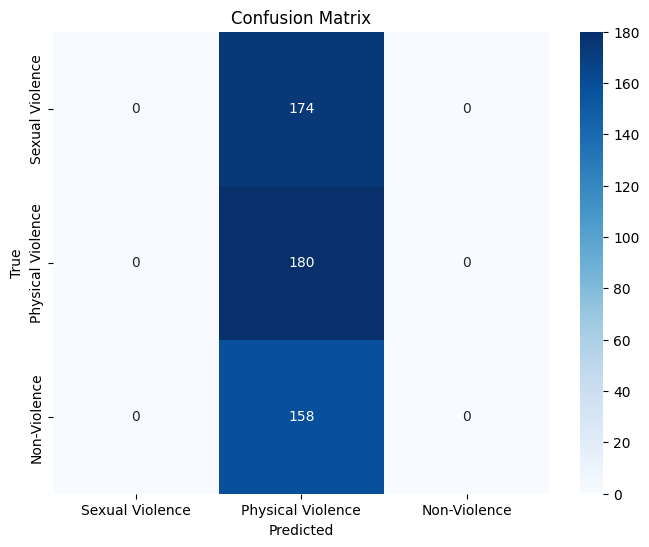

In [57]:
#Evaluation
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def evaluate_model(model, test_loader):
    # Set the model to evaluation mode
    model.eval()

    all_predictions = []
    all_true_labels = []

    # Iterate over batches in the test loader
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.no_grad():
            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask)

        # Get the logits
        logits = outputs.logits

        # Convert logits to predicted class labels
        predictions = np.argmax(logits.detach().cpu().numpy(), axis=1)
        true_labels = labels.cpu().numpy()

        # Collect predictions and true labels
        all_predictions.extend(predictions)
        all_true_labels.extend(true_labels)

    # Calculate evaluation metrics
    accuracy = accuracy_score(all_true_labels, all_predictions)
    class_report = classification_report(all_true_labels, all_predictions, target_names=['Sexual Violence', 'Physical Violence', 'Non-Violence'])
    conf_matrix = confusion_matrix(all_true_labels, all_predictions)

    # Print evaluation results
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(class_report)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sexual Violence', 'Physical Violence', 'Non-Violence'], yticklabels=['Sexual Violence', 'Physical Violence', 'Non-Violence'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, class_report, conf_matrix

# Evaluate the model on the test dataset
accuracy, class_report, conf_matrix = evaluate_model(model, test_loader_resampled)


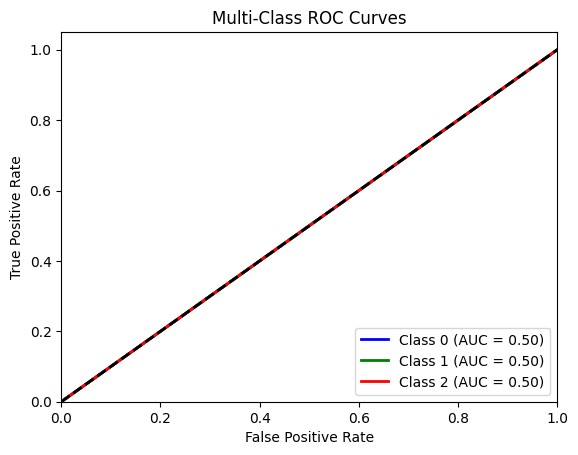

In [58]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

def plot_roc_curves(model, test_loader, num_classes=3):
    # Set the model to evaluation mode
    model.eval()

    all_true_labels = []
    all_pred_probs = []

    # Iterate over batches in the test loader
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.no_grad():
            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask)

        # Get the logits
        logits = outputs.logits
        pred_probs = torch.softmax(logits, dim=1).cpu().numpy()

        # Collect predictions and true labels
        all_pred_probs.extend(pred_probs)
        all_true_labels.extend(labels.cpu().numpy())

    # Binarize the labels for multi-class ROC
    all_true_labels_binarized = label_binarize(all_true_labels, classes=[0, 1, 2])
    all_pred_probs = np.array(all_pred_probs)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(all_true_labels_binarized[:, i], all_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure()
    colors = ['blue', 'green', 'red']
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curves')
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC curves
plot_roc_curves(model, test_loader_resampled)


DATA AUGMENTATION

In [66]:
!pip install imbalanced-learn transformers


In [68]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import torch
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# Download stopwords if not already available
nltk.download('stopwords')
nltk.download('punkt')

# Load the dataset
file_path = '/content/violencedataset.csv'
dataset = pd.read_csv(file_path, encoding='ISO-8859-1')

# Clean text function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return ' '.join(filtered_text)

# Apply the cleaning function to the 'text ' column
dataset['cleaned_text'] = dataset['text '].apply(clean_text)

# Define features and labels
X = dataset['cleaned_text']
y = dataset['label']

# Convert text labels to integers if not already
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Convert text data to TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# SMOTE for oversampling
smote = SMOTE(random_state=42)
X_train_resampled_tfidf, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Convert resampled TF-IDF vectors back to text
# Here, we take the TF-IDF matrix and convert it back into a list of text to feed into BERT
feature_names = tfidf_vectorizer.get_feature_names_out()
X_train_resampled_texts = [" ".join([feature_names[i] for i in row.nonzero()[1]]) for row in X_train_resampled_tfidf]

# Define Dataset class for PyTorch
class ViolenceDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True,
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Tokenizer and DataLoader setup
from transformers import BertTokenizer, BertForSequenceClassification

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define constants
MAX_LEN = 128
BATCH_SIZE = 16

# Prepare DataLoaders
train_dataset = ViolenceDataset(X_train_resampled_texts, y_train_resampled, tokenizer, MAX_LEN)
test_dataset = ViolenceDataset(X_test.tolist(), y_test, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model setup
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define optimizer and loss function
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)

# Training function
def train_epoch(model, data_loader, loss_fn, optimizer, device, n_examples):
    model = model.train()
    losses = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        losses += loss.item()
        loss.backward()
        optimizer.step()

    return losses / n_examples

# Evaluation function
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = 0
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)

            correct_predictions += torch.sum(preds == labels)
            losses += loss.item()

    return correct_predictions.double() / n_examples, losses / n_examples

# Training loop
EPOCHS = 3

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    train_loss = train_epoch(model, train_loader, CrossEntropyLoss(), optimizer, device, len(train_dataset))
    val_acc, val_loss = eval_model(model, test_loader, CrossEntropyLoss(), device, len(test_dataset))

    print(f'Train loss {train_loss} | Validation loss {val_loss} | Validation accuracy {val_acc}')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
Train loss 0.00306203694443506 | Validation loss 0.001079301263269761 | Validation accuracy 0.9965065502183407
Epoch 2/3
Train loss 0.0005972881858839544 | Validation loss 0.0008704522432958682 | Validation accuracy 0.9965065502183407
Epoch 3/3
Train loss 0.00024037061937346425 | Validation loss 0.0005380291799942487 | Validation accuracy 0.9978165938864629


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1570
           1       0.99      0.99      0.99       170
           2       0.99      1.00      1.00       550

    accuracy                           1.00      2290
   macro avg       1.00      1.00      1.00      2290
weighted avg       1.00      1.00      1.00      2290



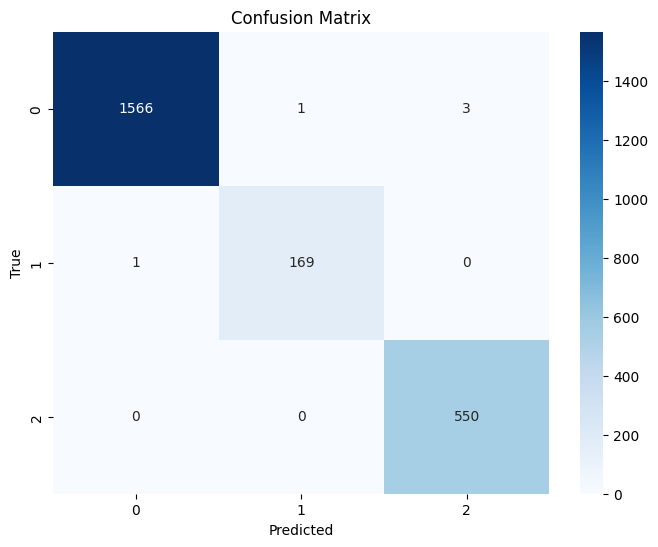

In [70]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Function to get predictions and labels from the model
def get_predictions(model, data_loader, device):
    model = model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return np.array(predictions), np.array(true_labels)

# Get predictions and true labels
y_pred, y_true = get_predictions(model, test_loader, device)

# Ensure that the label_encoder classes are strings
class_labels = label_encoder.inverse_transform(range(len(label_encoder.classes_)))

# Check if they are strings
class_labels = [str(label) for label in class_labels]

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


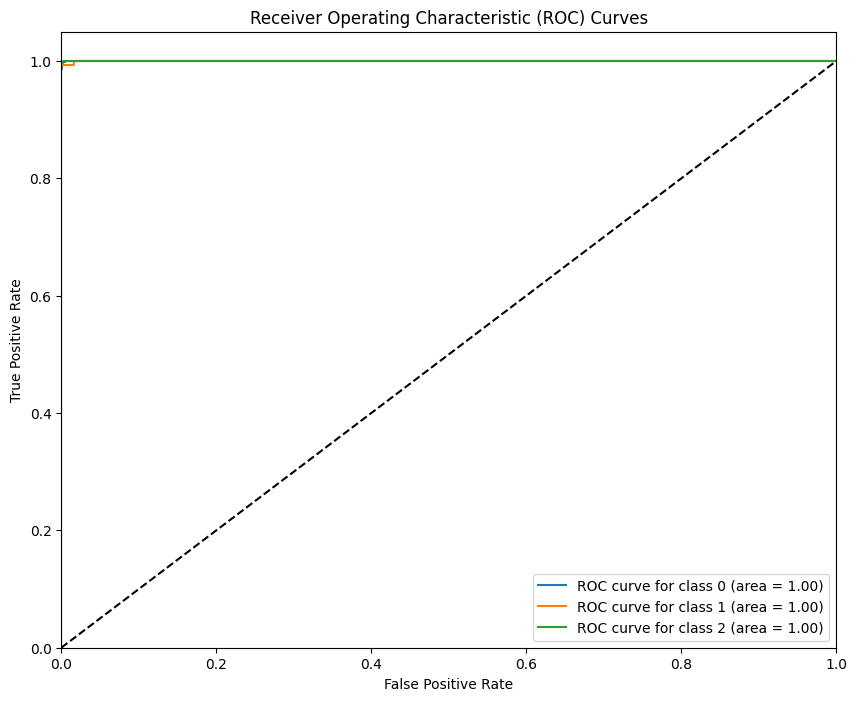

In [71]:
# Get predicted probabilities for ROC-AUC
def get_predictions_probs(model, data_loader, device):
    model = model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)

            predictions.extend(probs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return np.array(predictions), np.array(true_labels)

# Get predicted probabilities and true labels
y_probs, y_true = get_predictions_probs(model, test_loader, device)

# Binarize the labels for ROC-AUC calculation
y_true_binarized = label_binarize(y_true, classes=np.arange(len(label_encoder.classes_)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve for class {label_encoder.classes_[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()


Epoch 1/3
Train loss 0.00033417454282074204 | Validation loss 0.0006836989066829421 | Validation accuracy 0.9982532751091703
Epoch 2/3
Train loss 0.00011109979549726333 | Validation loss 0.0007918292914344888 | Validation accuracy 0.9978165938864629
Epoch 3/3
Train loss 0.00012434312938526922 | Validation loss 0.0012040407698916415 | Validation accuracy 0.9956331877729258


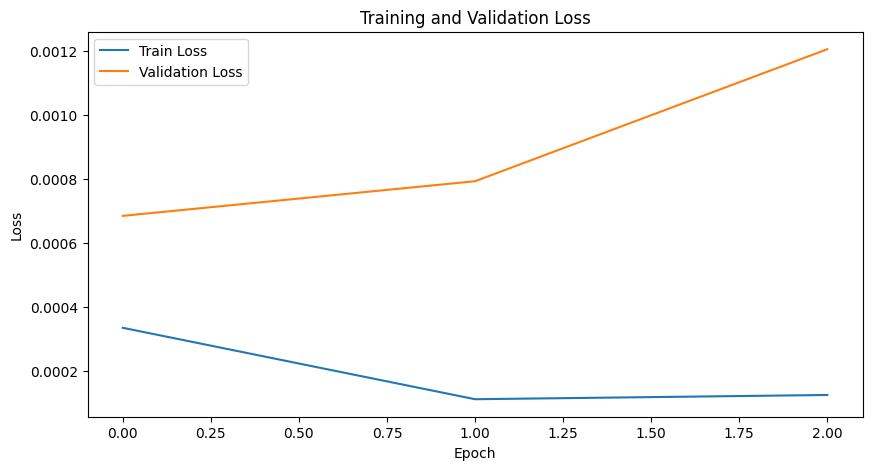

In [74]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Training loop with loss tracking
EPOCHS = 3
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    train_loss = train_epoch(model, train_loader, CrossEntropyLoss(), optimizer, device, len(train_dataset))
    val_acc, val_loss = eval_model(model, test_loader, CrossEntropyLoss(), device, len(test_dataset))

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Train loss {train_loss} | Validation loss {val_loss} | Validation accuracy {val_acc}')

# Plot training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [4]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Load the testing dataset
testing_data_path = '/content/Testingdata.xlsx'
testing_dataset = pd.read_excel(testing_data_path)

# Display the first few rows of the testing dataset
print(testing_dataset.head())

# Assume the text to be predicted is in a column named 'text'
testing_texts = testing_dataset['tweet']

# Load the tokenizer and model (make sure to match the model you used for training)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)  # Adjust the num_labels as needed
model.to('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare the testing data
encoded_inputs = tokenizer(testing_texts.tolist(), truncation=True, padding=True, max_length=128, return_tensors='pt')

# Move tensors to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_ids = encoded_inputs['input_ids'].to(device)
attention_mask = encoded_inputs['attention_mask'].to(device)

# Get predictions
with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1).cpu().numpy()

# Convert predictions to class labels
class_labels = ['sexual violence', 'physical violence', 'non-violence']  # Adjust this according to your label encoding
predicted_labels = [class_labels[pred] for pred in predictions]

# Add predictions to the testing dataset
testing_dataset['predictions'] = predicted_labels

# Display the first few rows with predictions
print(testing_dataset.head(51))



      Tweet_ID                                              tweet  \
0  ID_0058QG76  My Husband Beats Me Frequently, Wife Tells Cou...   
1  ID_00Q8YAZI  Best thing for me to do, is remain silent when...   
2  ID_00SF8ERO  My husband will never beat me, Bambam denies r...   
3  ID_00WHPES8  theyre like, i just wanna be a baby maker with...   
4  ID_00X0905O  I was in England for a week, the longest Iâ€™v...   

        Actual label  Predict label  
0  physical violence            NaN  
1  physical violence            NaN  
2  physical violence            NaN  
3  physical violence            NaN  
4  physical violence            NaN  


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


            Tweet_ID                                              tweet  \
0        ID_0058QG76  My Husband Beats Me Frequently, Wife Tells Cou...   
1        ID_00Q8YAZI  Best thing for me to do, is remain silent when...   
2        ID_00SF8ERO  My husband will never beat me, Bambam denies r...   
3        ID_00WHPES8  theyre like, i just wanna be a baby maker with...   
4        ID_00X0905O  I was in England for a week, the longest Iâ€™v...   
5        ID_019Q1JHV  "I'm unhappy with my husband, so I'm having an...   
6        ID_01AGEWV9  'My Wife Beats Me Constantly' - 75-Year-Old Hu...   
7        ID_01GT9Z2R  When the cops show up, very few battered wives...   
8        ID_01QLG1LC  Nothing beats my husband telling me I'm his be...   
9        ID_01YR7ASW  My husband beats me when heâ€™s feeling quirke...   
10       ID_01ZY85EM  Plss hide my iD and notify me when u post this...   
11       ID_0296YCM7  Wow i never thought you would admit it! RT My ...   
12       ID_0KT9UQPK  Ple